# Modeling

In [ ]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from pathlib import Path
from typing import Dict, List, Tuple

from sklearn import tree
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    mean_absolute_error,
    r2_score,
    root_mean_squared_error,
    confusion_matrix
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler 
from sklearn.svm import LinearSVC
from wordcloud import WordCloud

In [2]:
klachten = pd.read_csv("klachten.csv")

X = klachten["Omschrijving"].astype(str)
y = klachten["Product"].astype(str)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(10420,) (4467,)
(10420,) (4467,)


In [ ]:
def remove_punctuation(text: str) -> str:
    """Haal leestekens weg."""
    return re.sub(r"[^\w\s]", "", text)


stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def data_preprocessor(text: str) -> str:
    """Lowercase + leestekens weghalen."""
    text = text.lower()
    text = remove_punctuation(text)
    return text


def data_tokenizer(text: str):
    """
    1. Tokenizen
        2. Stopwoorden verwijderen
        3. Lemmatizen
        """
    #1
    tokens = word_tokenize(text, language="english")

    #2
    tokens = [t for t in tokens if t not in stop_words]

    #3
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens

In [4]:
vectorizer = TfidfVectorizer(
    lowercase=False,
    preprocessor=data_preprocessor,
    tokenizer=data_tokenizer,
    analyzer="word",
    stop_words=None,
    token_pattern=None
)

X_train_tfidf = vectorizer.fit_transform(X_train)

print("\nVorm van de TF-IDF-matrix:", X_train_tfidf.shape)
print("Features (woorden):", vectorizer.get_feature_names_out())


Vorm van de TF-IDF-matrix: (10420, 21106)
Features (woorden): ['0' '00' '000' ... 'zone' 'zoning' 'zwicker']


In [5]:
X_test_tfidf = vectorizer.transform(X_test)

print("Vorm X_train_tfidf:", X_train_tfidf.shape)
print("Vorm X_test_tfidf :", X_test_tfidf.shape)


Vorm X_train_tfidf: (10420, 21106)
Vorm X_test_tfidf : (4467, 21106)


In [ ]:
log_reg_model = LogisticRegression(
    multi_class="multinomial",
    max_iter=1000,
    n_jobs=-1
)

log_reg_model.fit(X_train_tfidf, y_train)

print("Model getraind!")


C:\Users\Matti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Model getraind!


In [ ]:
y_pred = log_reg_model.predict(X_test_tfidf)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy op de testset: {acc:.3f}\n")

print("Classification report:")
print(classification_report(y_test, y_pred))


Accuracy op de testset: 0.839

Classification report:
                    precision    recall  f1-score   support

      Bankrekening       0.86      0.82      0.84       447
Consumentenkrediet       0.84      0.47      0.60       284
        Creditcard       0.82      0.77      0.80       565
         Hypotheek       0.90      0.95      0.92       994
           Incasso       0.81      0.87      0.84      1229
Kredietregistratie       0.81      0.85      0.83       948

          accuracy                           0.84      4467
         macro avg       0.84      0.79      0.81      4467
      weighted avg       0.84      0.84      0.84      4467



In [10]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy (fractie):", accuracy)
print(f"Accuracy (procent): {accuracy * 100:.2f}%")


Accuracy (fractie): 0.8388179986568166
Accuracy (procent): 83.88%


In [13]:
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        preprocessor=data_preprocessor,
        tokenizer=data_tokenizer,
        lowercase=True,
        sublinear_tf=True
    )),
    ("clf", LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        max_iter=2000,
        n_jobs=-1
    ))
])

param_grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 3, 5],
    "tfidf__max_df": [0.9, 0.8],
    "clf__C": [0.5, 1.0, 3.0],
    "clf__class_weight": [None, "balanced"]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

print("Beste parameters:", grid.best_params_)
print(f"Beste cross-val accuracy: {grid.best_score_*100:.2f}%")

# Evaluatie op testset
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred)*100, "%")


Fitting 3 folds for each of 72 candidates, totalling 216 fits


C:\Users\Matti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Matti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Beste parameters: {'clf__C': 3.0, 'clf__class_weight': None, 'tfidf__max_df': 0.8, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}
Beste cross-val accuracy: 85.56%
Test accuracy: 85.40407432281172 %


In [20]:
baseline_acc = y.value_counts(normalize=True).iloc[0]
print(f"Baseline accuracy (altijd grootste klasse kiezen): {baseline_acc*100:.2f}%")

Baseline accuracy (altijd grootste klasse kiezen): 27.50%


## andere modellen
aangezien 85% nog geen 90/95% is
### LinearSVC


In [ ]:
svm_model = LinearSVC()

svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

print(f"SVM accuracy: {accuracy_score(y_test, y_pred_svm)*100:.2f}%")


SVM accuracy: 83.90%


LinearSVC (Linear Regression voor woorden) gaat het ook niet doen

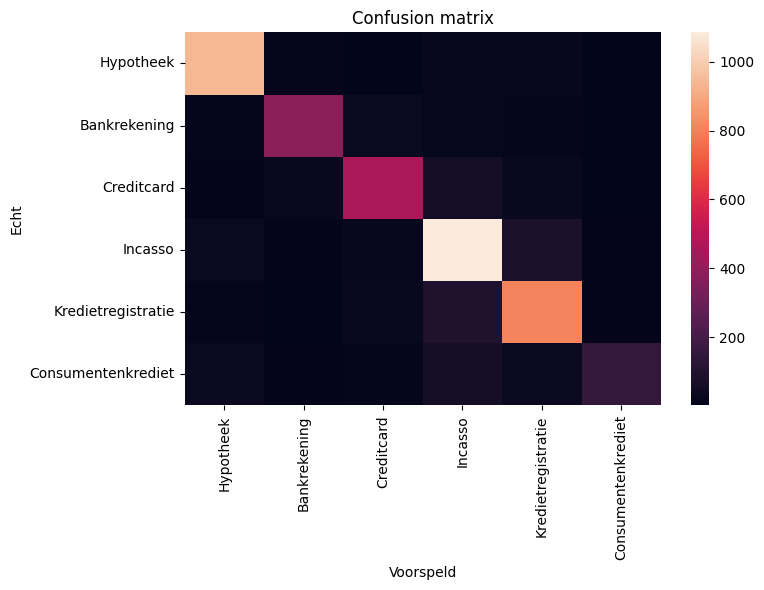

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, xticklabels=y_test.unique(), yticklabels=y_test.unique())
plt.xlabel("Voorspeld")
plt.ylabel("Echt")
plt.title("Confusion matrix")
plt.tight_layout()
plt.show()


Het gaat dus vooral fout op incasso en Hypotheek

### Native Bayes

In [17]:
nb_model = ComplementNB()
nb_model.fit(X_train_tfidf, y_train)

y_pred_nb = nb_model.predict(X_test_tfidf)
print(f"Naive Bayes accuracy: {accuracy_score(y_test, y_pred_nb)*100:.2f}%")


Naive Bayes accuracy: 81.15%


Dat is nog minder bruikbaar

### Character n-gram

In [ ]:
model_char = Pipeline([
    ("tfidf", TfidfVectorizer(
        analyzer="char",
        ngram_range=(3, 5),   # 3- t/m 5-grams over karakters
        sublinear_tf=True
    )),
    ("clf", LinearSVC())
])

model_char.fit(X_train, y_train)
y_pred_char = model_char.predict(X_test)

acc_char = accuracy_score(y_test, y_pred_char)
print(f"Character SVM accuracy: {acc_char*100:.2f}%")
print(classification_report(y_test, y_pred_char))

print(f"SVM accuracy: {accuracy_score(y_test, y_pred_svm)*100:.2f}%")


Character SVM accuracy: 86.03%
                    precision    recall  f1-score   support

      Bankrekening       0.86      0.83      0.84       447
Consumentenkrediet       0.83      0.57      0.68       284
        Creditcard       0.82      0.81      0.81       565
         Hypotheek       0.92      0.95      0.93       994
           Incasso       0.84      0.89      0.86      1229
Kredietregistratie       0.86      0.86      0.86       948

          accuracy                           0.86      4467
         macro avg       0.85      0.82      0.83      4467
      weighted avg       0.86      0.86      0.86      4467

SVM accuracy: 83.90%


is er bijna, maar nog net niet